## Access ARGO data in Parquet

A jupyter notebook to show how to access and plot ARGO Core data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/4402cb50-e20a-44ee-93e6-4728259250d2).

In [1]:
dataset_name = "argo"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 230 packages in 25ms


In [3]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

timestamp: int32
PLATFORM_NUMBER: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'PLATFORM_NUMBER')
print(list(unique_partition_value)[0:2])  # showing a subset only
len(unique_partition_value)

['1901748', '1901735']
CPU times: user 12.5 ms, sys: 155 µs, total: 12.6 ms
Wall time: 11.9 ms


124

## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:442: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:442: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


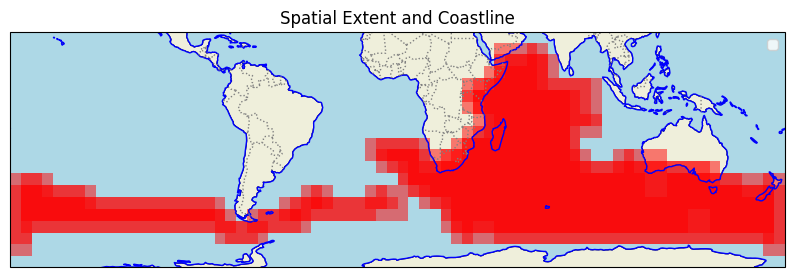

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2008, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2024, 1, 1, 0, 0, tzinfo=datetime.timezone.utc))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
get_schema_metadata(dname)  # schema metadata

{'DATA_TYPE': {'type': 'string',
  'long_name': 'Data type',
  'conventions': 'Argo reference table 1'},
 'FORMAT_VERSION': {'type': 'string', 'long_name': 'File format version'},
 'HANDBOOK_VERSION': {'type': 'string', 'long_name': 'Data handbook version'},
 'REFERENCE_DATE_TIME': {'type': 'string',
  'long_name': 'Date of reference for Julian days',
  'conventions': 'YYYYMMDDHHMISS'},
 'DATE_CREATION': {'type': 'string',
  'long_name': 'Date of file creation',
  'conventions': 'YYYYMMDDHHMISS'},
 'DATE_UPDATE': {'type': 'string',
  'long_name': 'Date of update of this file',
  'conventions': 'YYYYMMDDHHMISS'},
 'PLATFORM_NUMBER': {'type': 'string',
  'long_name': 'Float unique identifier',
  'conventions': 'WMO float identifier : A9IIIII'},
 'PROJECT_NAME': {'type': 'string', 'long_name': 'Name of the project'},
 'PI_NAME': {'type': 'string',
  'long_name': 'Name of the principal investigator'},
 'STATION_PARAMETERS': {'type': 'string',
  'long_name': 'List of available parameters fo

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2018-12-01', date_end='2023-01-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)


filter = filter_geo & filter_time

ValueError: No data for given bounding box. Amend lat/lon values 

In [ ]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

In [ ]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')

In [ ]:
import matplotlib.pyplot as plt


filtered_df = df[df['PLATFORM_NUMBER'] == 5905506]

# Get unique values of CYCLE_NUMBER
unique_cycle_numbers = filtered_df['CYCLE_NUMBER'].unique()

# Define a dictionary to map each unique CYCLE_NUMBER to a color
color_mapping = {cycle_number: plt.cm.viridis_r(i / len(unique_cycle_numbers)) for i, cycle_number in enumerate(unique_cycle_numbers)}

# Plot TEMP_ADJUSTED vs PRES_ADJUSTED with different colors for each line
for cycle_number, color in color_mapping.items():
    cycle_df = filtered_df[filtered_df['CYCLE_NUMBER'] == cycle_number]
    plt.plot(cycle_df['TEMP_ADJUSTED'], cycle_df['PRES_ADJUSTED'], color=color, label=f'Cycle {cycle_number}')

plt.xlabel('Temperature Adjusted')
plt.ylabel('Pressure Adjusted')
plt.title('Temperature vs Pressure')
plt.legend()
plt.grid(True)

# Reverse the y-axis
plt.gca().invert_yaxis()

plt.show()

## Create a TIME and scalar/number filter

In [12]:
filter_time = create_time_filter(parquet_ds, date_start='2006-07-12', date_end='2023-02-05')

expr_1 = pc.field('PLATFORM_NUMBER') == 1901740
filter = expr_1 & filter_time

In [13]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150192 entries, 0 to 150191
Data columns (total 67 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   PROJECT_NAME                  150192 non-null  object        
 1   PI_NAME                       150192 non-null  object        
 2   CYCLE_NUMBER                  150192 non-null  float64       
 3   DIRECTION                     150192 non-null  object        
 4   DATA_CENTRE                   150192 non-null  object        
 5   DC_REFERENCE                  150192 non-null  object        
 6   DATA_STATE_INDICATOR          150192 non-null  object        
 7   DATA_MODE                     150192 non-null  object        
 8   PLATFORM_TYPE                 150192 non-null  object        
 9   FLOAT_SERIAL_NO               150192 non-null  object        
 10  FIRMWARE_VERSION              150192 non-null  object        
 11  WMO_INST_TYPE

<Axes: title={'center': 'Temperature for each location'}, xlabel='TEMP_ADJUSTED', ylabel='PSAL_ADJUSTED'>

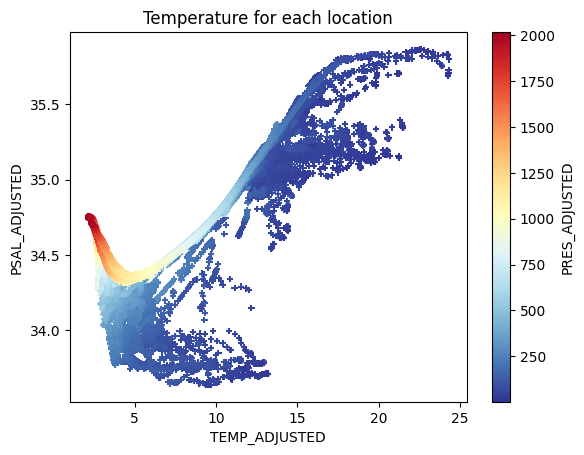

In [14]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')